In [1]:
import wandb
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

In [7]:
METRICS = ['Validation/total_unscaled_loss', 'Validation/unscaled_dyn_loss', 'Validation/value_prefix_loss', 'Validation/recon_loss', 'trainer/global_step']

In [2]:
api = wandb.Api()

In [14]:
if not os.path.exists('./perc_dropout_experiments/losses.npz'):
    os.makedirs('./perc_dropout_experiments', exist_ok=True)
    runs = api.runs("TomFrederik/MT-ToyTask-Ours", filters = {"group": "dense_perc_dropout"})
    losses = {}
    for run in tqdm(runs):
        path = os.path.join('./per_dropout_experiments', run.id)
        setting = run.id.split("_")[1]
        # if setting not in ['0', '2', '4', '6']:
        #     continue
        
        if setting not in losses:
            losses[setting] = []
        history = run.scan_history(keys=METRICS)
        loss = {metric: [row[metric] for row in history] for metric in METRICS}
        losses[setting].append(loss)

    for key, value in losses.items():
        losses[key] = {metric: np.array([run[metric] for run in losses[key]]) for metric in METRICS}
    np.savez_compressed('./perc_dropout_experiments/losses.npz', **losses)
# else:
#     losses = np.load('./perc_dropout_experiments/losses.npz')

100%|██████████| 44/44 [03:08<00:00,  4.29s/it]


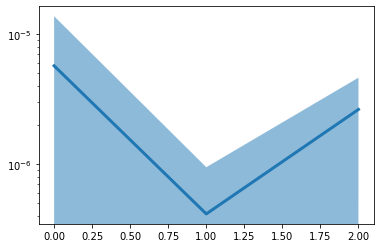

In [39]:
for key, val in losses.items():
    # if key not in ['0', '2', '4', '6']:
    if key not in ['0', '2']:
        continue
    value = val['Validation/value_prefix_loss']
    if value.dtype != np.float64: # is nan
        continue
    mean = value.mean(axis=0)
    std = value.std(axis=0)
    plt.figure()
    plt.plot(mean, linewidth=3)
    plt.fill_between(np.arange(3), mean-std, mean+std, alpha=0.5)
    plt.yscale('log')
    plt.show()